# MORE plot

Implmentation of Measure of Risk and Error Plots. From Nelson 2008.
https://ieeexplore.ieee.org/document/4736095    

## Imports

In [1]:
import numpy as np
import pandas as pd
import warnings

## Example data used with a MORE plot.

This is replication data.  Each row is a replication and each column is a KPI

In [2]:
SEED = 42
COUNT = 75

rng = np.random.default_rng(SEED)
results = pd.DataFrame(rng.normal(100, 10, (COUNT, 5)))
results.head()

,0,1,2,3,4
0,103.047171,89.600159,107.504512,109.405647,80.489648
1,86.978205,101.278404,96.837574,99.831988,91.469561
2,108.793980,107.777919,100.660307,111.272412,104.675093
3,91.407075,103.687508,90.411174,108.784503,99.500741
4,98.151376,93.190705,112.225413,98.454705,95.716722


## Implementation

### Supporting Funcs

In [3]:
def ci_for_sample_mean(mean_value, std, n, critical_value=1.96):
    '''Confidence interval for mean.  Assume std is sample std.
    
    Notes:
    ------
    
    critical value hard coded at the moment.  
    Should update to use t dist.
    '''
    half_width = (critical_value * (std / np.sqrt(n)))
    mean_lower = mean_value - half_width
    mean_upper = mean_value + half_width
    return mean_lower, mean_upper
    

In [4]:
def ci_percentile(results, field, percentile, critical_value=1.96):
    '''Approximate confidence interval for percentile.
    Note these may or may not be symmetric.
    
    Notes:
    ------
    
    critical value hard coded at the moment.  
    Should update to use t dist.
    
    Params:
    ------
    results: pd.DataFrame
        Results dataframe - tabular data where each row is a rep and each col is a KPI
        
    field: int
        Field from data frame to analyse
        
    percentile: float
        The percentile around which to form the CI
        
    critical_value: float, optional (default = 1.96)
        critical value of the normal dist to use.
    '''
    half_width = critical_value * np.sqrt((percentile * (1 - percentile)) / (len(results) - 1))
    y_beta_1 = results[field].quantile(percentile - half_width)
    y_beta_2 = results[field].quantile(percentile + half_width)
    return y_beta_1, y_beta_2

In [5]:
def as_horizontal_axis_fraction(value, xmin, xmax):
    '''Convert a axis value to a fraction accounting for the 
    minimum on the xaxis (i.e. axis may not start from 0).
    '''
    return (value - xmin) / (xmax - xmin)

In [6]:
def draw_interval(ax, start, end, style="|-|", lw=3, color='b'):
    '''Annotate a matplotlib chart underneath x axis with an confidence interval.
    '''
    _ = ax.annotate('', xy=(start, -0.1), xycoords='axes fraction', 
                       xytext=(end, -0.1),
                       arrowprops=dict(arrowstyle=style, color=color, lw=lw))

### Main

In [7]:
def more_plot(results, field=0, bins=None, figsize=(8, 5), percentiles=(0.05, 0.95), surpress_warnings=False):
    '''Measure of Risk and Error (MORE) plot.
    
    Risk illustrated via likely and unlikely ranges of replication values. 
    Erorr illustrated for CIs for mean and wide approx confidence intervals for percentiles
        
    Confidence intervals for percentiles will only be calculated if > 80 replications due to 
    approximation accuracy.
    
    Notes:
    ------
    Each value plotted represents the mean of a replication (e.g. daily throughput).  It should
    not be confused with an individuals results (e.g. an individuals throughput time). 
    
    If the system modelled contains time dependency the MORE plot may hide time of day/event effects.
    
    Params:
    ------
    results: pd.DataFrame
        Tabular data of replications. each column is a kpi
        
    field: int
        ID of column containing relevant data
        
    bins: int, optional (default=None)
        no. bins to generate. None=pandas decides no.
        
    figsize: tuple, optional (default=(8,5))
        size of plot
        
    
    Returns:
    -------
    fig, ax
    
    Refs:
    -----
    
    Nelson 2008. (Winter Simulation Paper)
    https://ieeexplore.ieee.org/document/4736095    
    
    '''
    
    # probably will shift these to module level scope.
    LIKELY = 'LIKELY'
    UNLIKELY = 'UNLIKELY'
    FONT_SIZE = 12
    LINE_WIDTH = 3
    LINE_STYLE = '-'
    CRIT_VALUE = 1.96
    UPPER_QUANTILE = percentiles[1]
    LOWER_QUANTILE = percentiles[0]
    INTERVAL_LW = 2
    MIN_N_FOR_PERCENTILE = 80
    WARN = f'CIs for percentiles are not generated as sample size < {MIN_N_FOR_PERCENTILE}.'
    WARN += ' To supress this msg set `supress_warnings=True`'

    ax = results[field].hist(bins=bins, figsize=figsize)
    mean = results[field].mean()
    std = results[field].std(ddof=1)
    upper_percentile = results[field].quantile(UPPER_QUANTILE)
    lower_percentile = results[field].quantile(LOWER_QUANTILE)

    # vertical lines
    ax.axvline(x=mean, linestyle='-', color='black', linewidth=LINE_WIDTH)
    ax.axvline(x=upper_percentile, linestyle='-', color='red', linewidth=LINE_WIDTH)
    ax.axvline(x=lower_percentile, linestyle='-', color='red', linewidth=LINE_WIDTH)

    like_font = {'family': 'serif',
                 'color':  'black',
                 'weight': 'bold',
                 'size': FONT_SIZE
                 }
    unlike_font = {'family': 'serif',
                 'color':  'red',
                 'weight': 'bold',
                 'size': FONT_SIZE
                 }

    # add text
    txt_offset = ax.get_ylim()[1] * 1.05
    ax.text(mean - (mean * 0.02), txt_offset, LIKELY, fontdict=like_font)
    ax.text(upper_percentile, txt_offset, UNLIKELY, fontdict=unlike_font)
    ax.text(ax.get_xlim()[0], txt_offset, UNLIKELY, fontdict=unlike_font)

    # calculate and display confidence intervals

    ## CIs for sample mean
    mean_lower, mean_upper = ci_for_sample_mean(mean, std, len(results))
    
    # Draw Confidence intervals
    # The horizontal lines are expressed as an axis fraction i.e. between 0 and 1.  
    # This means thatthe percentile CIs need to be converted before plotting.
    # The function as_horizontal_axis_fraction is used.

    ## mean CI  
    hline_mean_from = as_horizontal_axis_fraction(mean_lower, ax.get_xlim()[0], ax.get_xlim()[1])
    hline_mean_to = as_horizontal_axis_fraction(mean_upper, ax.get_xlim()[0], ax.get_xlim()[1])
    draw_interval(ax, hline_mean_from, hline_mean_to, lw=INTERVAL_LW)
    
    # avoid approximation issues with small samples.  
    if len(results) >= MIN_N_FOR_PERCENTILE:
        ## upper percentile
        y_beta_1, y_beta_2 = ci_percentile(results, field, UPPER_QUANTILE, critical_value=CRIT_VALUE)

        ## lower percentile
        y_beta_l_1, y_beta_l_2 = ci_percentile(results, field, LOWER_QUANTILE, critical_value=CRIT_VALUE)
        
        ## line for upper quantile CI
        hline_upper_q_from = (y_beta_1 - ax.get_xlim()[0]) / (ax.get_xlim()[1] - ax.get_xlim()[0])
        hline_upper_q_to = (y_beta_2 - ax.get_xlim()[0]) / (ax.get_xlim()[1] - ax.get_xlim()[0])
        
        hline_upper_q_from = as_horizontal_axis_fraction(y_beta_1, ax.get_xlim()[0], ax.get_xlim()[1])
        hline_upper_q_to = as_horizontal_axis_fraction(y_beta_2, ax.get_xlim()[0], ax.get_xlim()[1])
        draw_interval(ax, hline_upper_q_from, hline_upper_q_to, lw=INTERVAL_LW)
        
        ## line for lower quantile CI
        hline_lower_q_from = (y_beta_l_1 - ax.get_xlim()[0]) / (ax.get_xlim()[1] - ax.get_xlim()[0])
        hline_lower_q_to = (y_beta_l_2 - ax.get_xlim()[0]) / (ax.get_xlim()[1] - ax.get_xlim()[0])
        
        hline_lower_q_from = as_horizontal_axis_fraction(y_beta_l_1, ax.get_xlim()[0], ax.get_xlim()[1])
        hline_lower_q_to = as_horizontal_axis_fraction(y_beta_l_2, ax.get_xlim()[0], ax.get_xlim()[1])
        draw_interval(ax, hline_lower_q_from, hline_lower_q_to, lw=INTERVAL_LW)
        
    elif not surpress_warnings:
        warnings.warn(WARN)
        
    
    return ax.figure, ax

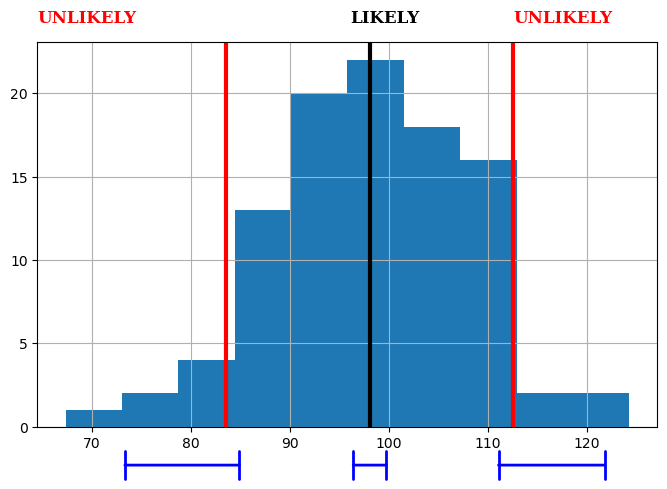

In [8]:
# test 1

SEED = 101
COUNT = 100

rng = np.random.default_rng(SEED)
results = pd.DataFrame(rng.normal(100, 10, (COUNT, 5)))
results.head()

fig, ax = more_plot(results)

/tmp/ipykernel_7580/2129958795.py:126: UserWarning: CIs for percentiles are not generated as sample size < 80. To supress this msg set `supress_warnings=True`
  warnings.warn(WARN)


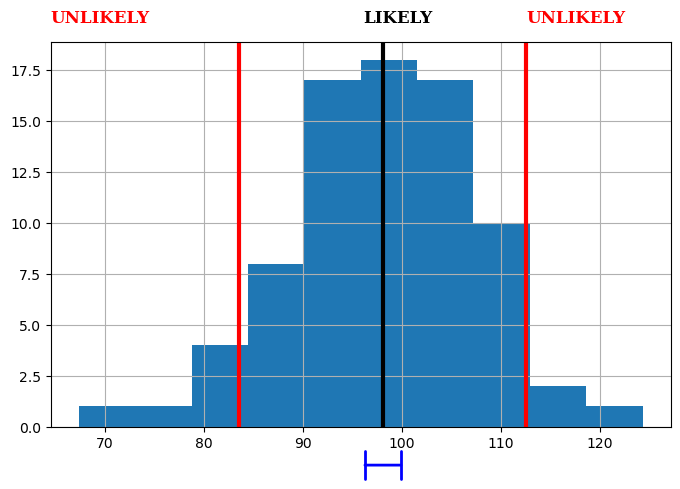

In [9]:
# test 2: small sample (< 80), warnings not surpressed.

SEED = 101
COUNT = 79

rng = np.random.default_rng(SEED)
results = pd.DataFrame(rng.normal(100, 10, (COUNT, 5)))
results.head()

fig, ax = more_plot(results)

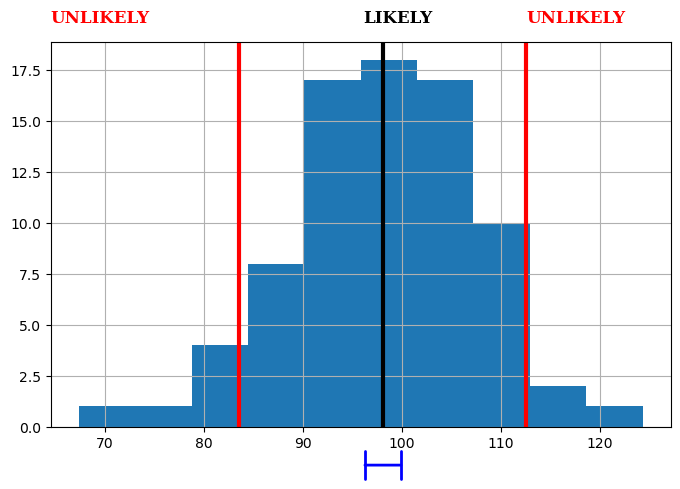

In [10]:
# test 3: small sample (< 80), warnings are surpressed.

SEED = 101
COUNT = 79

rng = np.random.default_rng(SEED)
results = pd.DataFrame(rng.normal(100, 10, (COUNT, 5)))
results.head()

fig, ax = more_plot(results, surpress_warnings=True)

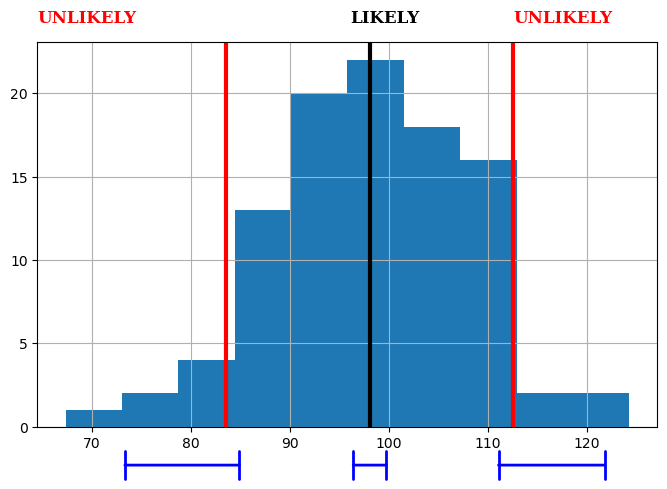

In [11]:
# save to file in normal way

SEED = 101
COUNT = 100

rng = np.random.default_rng(SEED)
results = pd.DataFrame(rng.normal(100, 10, (COUNT, 5)))
results.head()

fig, ax = more_plot(results)

fig.savefig('more_plot.png', dpi=300, bbox_inches='tight')

In [12]:
# Plotly
# https://stackoverflow.com/questions/40629949/python-plotly-multiple-histogram-with-mean-line

In [13]:
def ci_percentile(results, field, percentile, critical_value=1.96):
    '''Approximate confidence interval for percentile.
    Note these may or may not be symmetric.
    
    Notes:
    ------
    
    critical value hard coded at the moment.  
    Should update to use t dist.
    
    Params:
    ------
    results: np.array
        Results array - tabular data where each row is a rep and each col is a KPI
        
    field: int
        Field from data frame to analyse
        
    percentile: float
        The percentile around which to form the CI
        
    critical_value: float, optional (default = 1.96)
        critical value of the normal dist to use.
    '''
    half_width = critical_value * np.sqrt((percentile * (1 - percentile)) / (len(results) - 1))
    y_beta_1 = results[field].quantile(percentile - half_width)
    y_beta_2 = results[field].quantile(percentile + half_width)
    return y_beta_1, y_beta_2

In [16]:
import numpy as np
import plotly.express as px
import plotly.graph_objects as go

def more_plotly(data, x_label, percentiles=(0.05, 0.95), surpress_warnings=False):
    """
    Plots a histogram of the input numpy array 'data' using Plotly Express.
    The bars corresponding to values below the 5th percentile and above the 95th percentile are colored red.
    Additionally, it adds three vertical dotted lines at the mean, 5th percentile, and 95th percentile.
    It also adds a transparent vertical rectangle representing the 95% confidence interval for the mean.
    
    Args:
        data (numpy.ndarray): The input data to be plotted.
        x_label (str): The label for the x-axis.
    
    Returns:
        plotly.graph_objects.Figure: The Plotly figure object.
    """

     # probably will shift these to module level scope.
    LIKELY = 'LIKELY'
    UNLIKELY = 'UNLIKELY'
    FONT_SIZE = 12
    LINE_WIDTH = 3
    LINE_STYLE = '-'
    CRIT_VALUE = 1.96
    UPPER_QUANTILE = percentiles[1]
    LOWER_QUANTILE = percentiles[0]
    INTERVAL_LW = 2
    MIN_N_FOR_PERCENTILE = 80
    WARN = f'CIs for percentiles are not generated as sample size < {MIN_N_FOR_PERCENTILE}.'
    WARN += ' To supress this msg set `supress_warnings=True`'

    # Calculate the 5th and 95th percentiles and round them up to the nearest integer
    p5 = np.ceil(np.percentile(data, LOWER_QUANTILE*100)).astype(int)
    p95 = np.ceil(np.percentile(data, UPPER_QUANTILE*100)).astype(int)
    mean = np.mean(data)
    
    # Calculate the 95% confidence interval for the mean
    std_err = np.std(data) / np.sqrt(len(data))
    lower_limit = mean - CRIT_VALUE * std_err
    upper_limit = mean + CRIT_VALUE * std_err
    
    # Calculate the histogram using NumPy
    counts, bins = np.histogram(data, bins='auto')
     
    # Determine the color for each bin
    colors = np.where((bins[:-1] < p5) | (bins[:-1] >= p95), UNLIKELY, LIKELY)
    
    # Create the color map for the histogram
    color_discrete_map = {
        LIKELY: '#4CAF50',  # Green
        UNLIKELY: '#F44336'  # Red
    }
    
    # Create the Plotly figure (uses plotly express - needs updated to `go`)
    fig = px.bar(x=bins[:-1], y=counts, color=colors, color_discrete_map=color_discrete_map,
                 range_x=[np.min(data),np.max(data) * 1.02])
    
    # remove gap between bars
    fig.update_layout(bargap=0.00, xaxis_title=x_label, legend_title=None, yaxis_title="Replications")

    # Add the vertical dotted lines
    fig.add_vline(x=mean, line_width=2, line_dash="dot", line_color="black", annotation_text="mean")
    fig.add_vline(x=p5, line_width=2, line_dash="dot", line_color="black", 
                  annotation_text="5th", annotation_position="top left")
    fig.add_vline(x=p95, line_width=2, line_dash="dot", line_color="black", annotation_text="95th")
    
    
    # Add CI for mean
    fig.add_vrect(x0=lower_limit, x1=upper_limit, line_width=0, fillcolor="#FFA726", opacity=0.5)  # Orange  

    # avoid approximation issues with small samples.  
    if len(data) >= MIN_N_FOR_PERCENTILE:

        # add the percentile large sample confidence intervals
        df = pd.DataFrame(data)
        df.columns = ['KPI']
        
        x0, x1 = ci_percentile(df, "KPI", 0.95)
        fig.add_vrect(x0=x0, x1=x1, 
                      line_width=0, 
                      fillcolor="#FFA726", 
                      opacity=0.4,
                      showlegend=False,
                      name="CI 95th Percentile")  # Orange

        x0, x1 = ci_percentile(df, "KPI", 0.05)
        fig.add_vrect(x0=x0, x1=x1, 
                      line_width=0, 
                      fillcolor="#FFA726", 
                      opacity=0.4, 
                      showlegend=False,
                      name="CI 5th Percentile")  # Orange

    
    elif not surpress_warnings:
        warnings.warn(WARN)

    note = 'Shaded regions around vertical lines are 95% Confidence Intervals'
    fig.add_annotation(
        showarrow=False,
        text=note,
        font=dict(size=10), 
        xref='x domain',
        x=0.0,
        yref='y domain',
        y=-0.25
        )

    # update legend position
    fig.update_layout(legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    ))

    return fig


In [17]:
SEED = 101
COUNT = 100

rng = np.random.default_rng(SEED)
results = pd.DataFrame(rng.normal(100, 10, (COUNT, 5)))

more_plotly(results[0].to_numpy(), "KPI")